# Titanic Clusterization Example - Using SQL Datasource

Cluster is an example of "unsupervised learning" as we do not know or use the ground truth to train the algorithm.  
Instead the algorithm looks at the data and decides what to do (in this case cluster the data together into groups it "thinks" are alike).  
This version of Titanic Clusterization starts with the data in a SQL/jdbc table. 

## i. Import necessary modules 
Also set some Pandas defaults

In [36]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## ii. Initialize JDBC Connection Info
  
Note, it may be necessary downgrade Python jpype1 to version 0.6.3 for this to work!

In [5]:
import jaydebeapi as jay
import os

# Ignite Server Details
dsn_hostname = "localhost"
dsn_port = "10838"
dsn_uid = "ignite"
dsn_pwd = "ignite"
dsn_schema = "TITANIC"

# Driver Properties?
dsn_props = ""

# Ignite JDBC class name
jdbc_driver_name = "org.apache.ignite.IgniteJdbcThinDriver"

# JDBC driver path
#jdbc_driver_loc = os.path.join(r'/mnt/c/apps/gridgain-ultimate/libs/ignite-core-8.7.14.jar') # if kernel on linux
jdbc_driver_loc = os.path.join(r'C:\\apps\\gridgain-ultimate-8.7.14\\libs\\ignite-core-8.7.14.jar') # if kernel on Windows

# Sample SQL Query
sql_str = "SELECT * FROM TITANIC"

# JDBC connection string
connection_string='jdbc:ignite:thin://'+ dsn_hostname + ':' + dsn_port + '/' + dsn_schema

url = '{0}:user={1}; password={2}'.format(connection_string, dsn_uid, dsn_pwd)
print("Connection String: " + connection_string)

Connection String: jdbc:ignite:thin://localhost:10838/TITANIC


## iii. Get Connection to Database

In [4]:
# Establish JDBC connection
conn = jay.connect(jdbc_driver_name, connection_string, {}, jars=jdbc_driver_loc)
cursor = conn.cursor()

## 1. Get data into kernel (from JDBC SQL Table)
Here we:
- define a SQL query
- execute the query on a cursor
- get the results
- initialize a DataFrame from the results 
- take a peek & print the first few rows (head() method

In [57]:
#df = pd.read_csv('../../Data/titanic.csv') <== convert to reading from SQL

# Query to read Titanic Table
sql_str = "SELECT PASSENGERID, SURVIVED, PCLASS, NAME, SEX, AGE, SIBSP, PARCH, TICKET, FARE, CABIN, EMBARKED " + \
          "  FROM TITANIC.TITANIC;"

# Execute query (against cursor)
cursor.execute(sql_str)

# Get the result set
sql_results = cursor.fetchall()

# Convert resluts to Panadas DataFrame... and give it the actual column names too
df = pd.DataFrame(sql_results)
df.columns = [i[0] for i in cursor.description]

# Print the top/head of the dataframe 
print(df.head())

PASSENGERID  SURVIVED  PCLASS                                               NAME     SEX   AGE  SIBSP  PARCH   TICKET     FARE  CABIN EMBARKED
0          128         1       3                          Madsen, Mr. Fridtjof Arne    male  24.0      0      0  C 17369   7.1417               S
1          384         1       1  Holverson, Mrs. Alexander Oskar (Mary Aline To...  female  35.0      1      0   113789  52.0000               S
2          640         0       3                         Thorneycroft, Mr. Percival    male   0.0      1      0   376564  16.1000               S
3          129         1       3                                  Peter, Miss. Anna  female   0.0      1      1     2668  22.3583  F E69        C
4          385         0       3                             Plotcharsky, Mr. Vasil    male   0.0      0      0   349227   7.8958               S


## 2. Profile the data

Here we use Pandas's Dataframe describe function.  
For more thorough/detailed profiling look at pandas-profiling library and run a profile_report.

In [58]:
df.describe()

#import pandas_profiling
#df.profile_report()

,PASSENGERID,SURVIVED,PCLASS,AGE,SIBSP,PARCH,FARE
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,23.799293,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,17.596074,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,6.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3. Perform common dataset operations

- Select desired/necessary fields
- Fill holes in data
- normalize data
- map Strings to values

In [59]:
# Select fields of use - here we remove the Name column as it does not contribute to clustering/classification
df.drop(['PASSENGERID', 'NAME','TICKET'], 1, inplace=True)

# Continue and map different literals to values
df['SEX']      = df['SEX'].map({'female': 1, 'male': 0})
df['EMBARKED'] = df['EMBARKED'].map({'C': 1, 'S': 0})
df['CABIN'].fillna(0, inplace=True)
df['CABIN']    = df['CABIN'].map({0: 0}).fillna(1)

# General fill holes with 0 value
df.fillna(0, inplace=True)
print(df.head(20))

# Re-print the profile
df.describe()

SURVIVED  PCLASS  SEX    AGE  SIBSP  PARCH     FARE  CABIN  EMBARKED
0          1       3    0  24.00      0      0   7.1417    1.0       0.0
1          1       1    1  35.00      1      0  52.0000    1.0       0.0
2          0       3    0   0.00      1      0  16.1000    1.0       0.0
3          1       3    1   0.00      1      1  22.3583    1.0       1.0
4          0       3    0   0.00      0      0   7.8958    1.0       0.0
5          0       3    0  20.00      0      0   7.8542    1.0       0.0
6          0       3    0  45.00      0      0   6.9750    1.0       0.0
7          0       2    0  18.00      0      0  73.5000    1.0       0.0
8          1       1    1  24.00      0      0  69.3000    1.0       1.0
9          0       3    0  33.00      0      0   7.8958    1.0       1.0
10         0       3    0   1.00      5      2  46.9000    1.0       0.0
11         0       3    1   2.00      3      2  27.9000    1.0       0.0
12         0       3    0  20.00      0      0   7.0500

,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,CABIN,EMBARKED
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.0,891.000000
mean,0.383838,2.308642,0.352413,23.799293,0.523008,0.381594,32.204208,1.0,0.188552
std,0.486592,0.836071,0.477990,17.596074,1.102743,0.806057,49.693429,0.0,0.391372
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,2.000000,0.000000,6.000000,0.000000,0.000000,7.910400,1.0,0.000000
50%,0.000000,3.000000,0.000000,24.000000,0.000000,0.000000,14.454200,1.0,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.0,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.0,1.000000


## 4. K Means Model for Firm Clustering 

Let's create 2 clusters

In [60]:
X = np.array(df.drop(['SURVIVED'], 1).astype(float))
y = np.array(df['SURVIVED'])

clf = KMeans(n_clusters=2)
clf.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## 5. Test accuracy of clusters to ground truth

In [66]:
# Test clusters against ground truth of real survivorship
correct = 0
for i in range(len(X)):
    predict_passenger = np.array(X[i].astype(float))
    predict_passenger = predict_passenger.reshape(-1, len(predict_passenger))
    prediction = clf.predict(predict_passenger)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.3557800224466891


## 6. Visualize Results

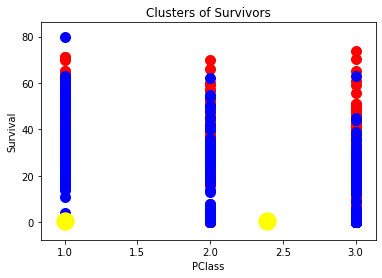

In [62]:
# Import plotting library
import matplotlib.pyplot as plt

#6 Visualising the clusters
plt.scatter(X[y==0, 0], X[y==0, 2], s=100, c='red', label ='Not Survived')
plt.scatter(X[y==1, 0], X[y==1, 2], s=100, c='blue', label ='Survived')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Survivors')
plt.xlabel('PClass')
plt.ylabel('Survival')
plt.show()

In [69]:
### More advanced clustering
# for name in ('NotSurvived','Survived'):

#     trace = Scatter(
#         x=Y_sklearn[y==name,0],
#         y=Y_sklearn[y==name,1],
#         mode='markers',
#         name=name,
#         marker=Marker(
#             size=10,
#             line=Line(
#                 color='rgba(217, 217, 217, 0.14)',
#                 width=0.5),
#             opacity=0.8))
#     traces.append(trace)


# data = Data(traces)
# layout = Layout(showlegend=True,
#                 scene=Scene(xaxis=XAxis(title='PC1'),
#                 yaxis=YAxis(title='PC2'),))

# fig = Figure(data=data, layout=layout)
# iplot(fig)